### 개선된 U-Net 모델 만들기

### Import model

In [1]:
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *


In [2]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

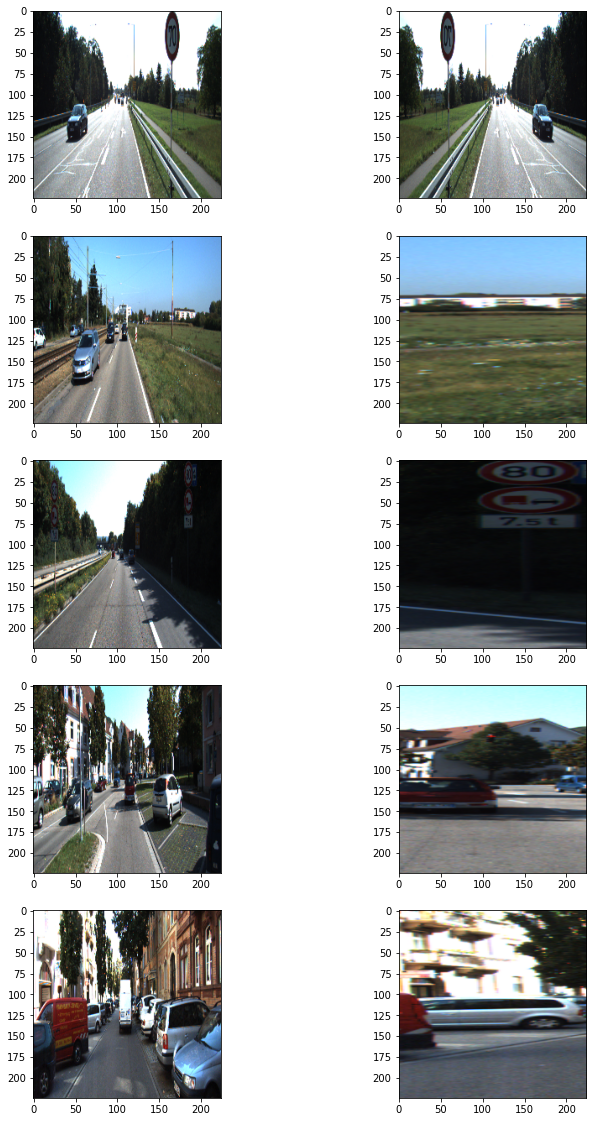

In [3]:
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

In [4]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=16,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [5]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

In [6]:
def build_model(input_shape=(224, 224, 3)):
  inputs = Input(input_shape)
	
  #Contracting Path
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
  
  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)
  
  #Expanding Path
  drop5 = Dropout(0.5)(conv5)
  up6 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop5)
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
  up7 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv6)
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
  up8 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv7)
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
  up9 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv8)
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
  conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
  conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

  model = Model(inputs = inputs, outputs = conv10)
  return model

In [7]:
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

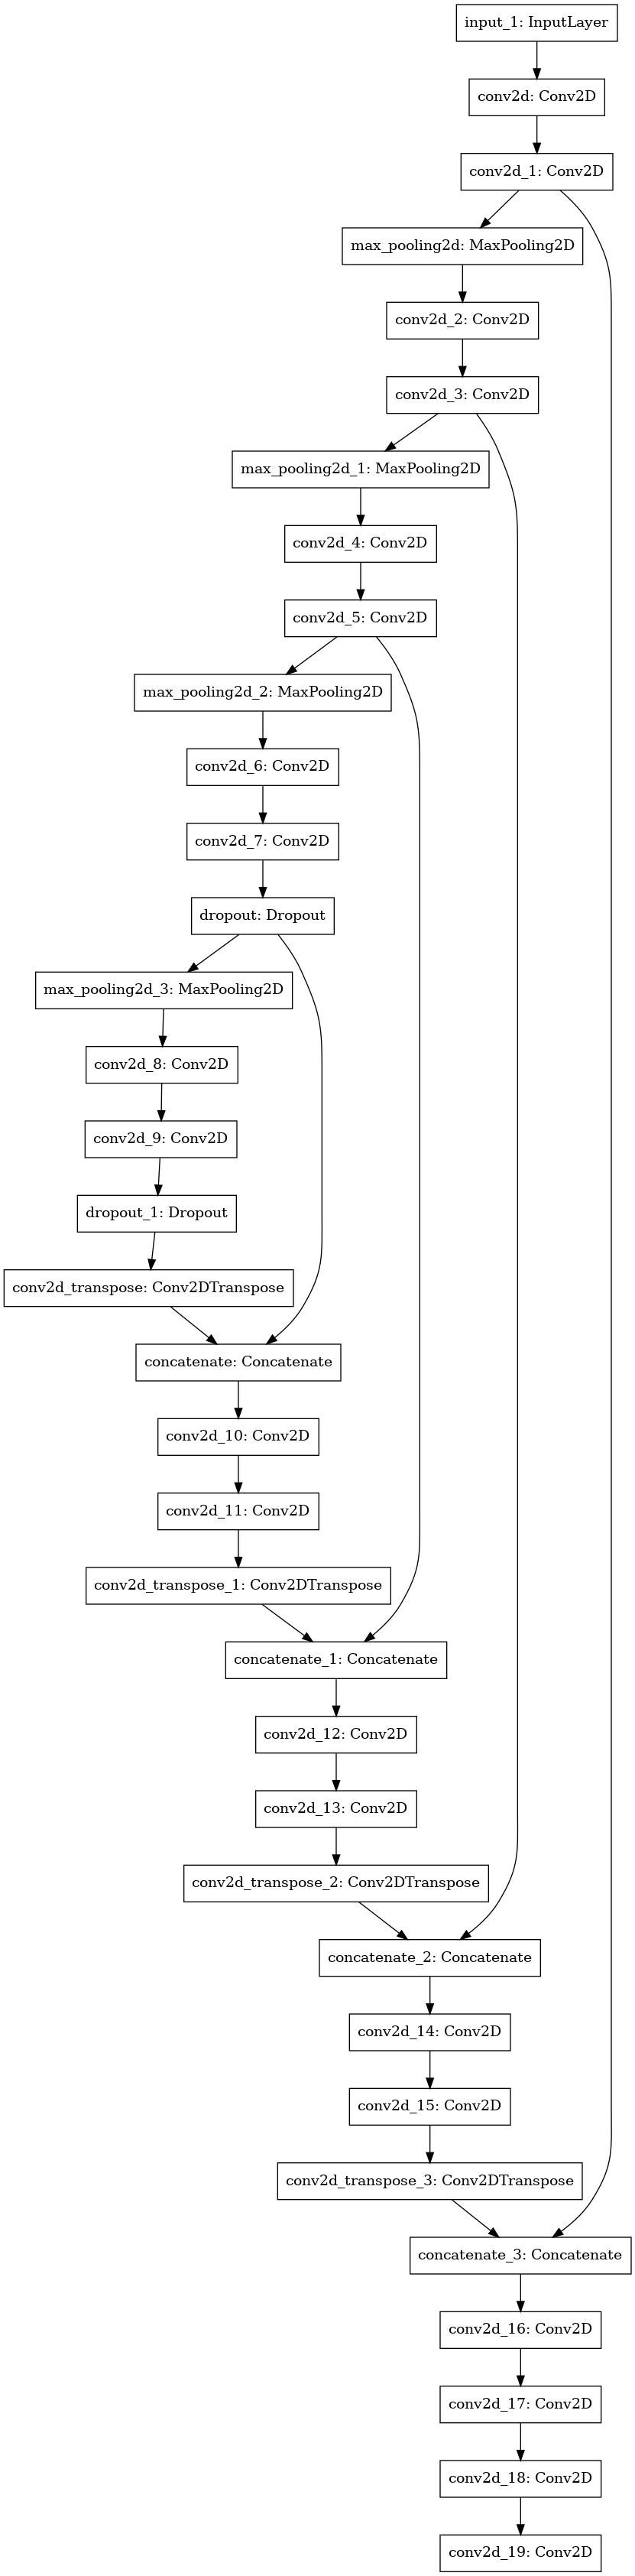

In [8]:
tf.keras.utils.plot_model(model, to_file='model.png')

In [9]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'


model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
11/11 [==============================] - 56s 594ms/step - loss: 0.6878 - val_loss: 0.6749
Epoch 2/100
11/11 [==============================] - 6s 568ms/step - loss: 0.4974 - val_loss: 0.0460
Epoch 3/100
11/11 [==============================] - 6s 558ms/step - loss: 0.0327 - val_loss: 0.0292
Epoch 4/100
11/11 [==============================] - 6s 559ms/step - loss: 0.0336 - val_loss: 0.0369
Epoch 5/100
11/11 [==============================] - 6s 563ms/step - loss: 0.0291 - val_loss: 0.0369
Epoch 6/100
11/11 [==============================] - 6s 566ms/step - loss: 0.0305 - val_loss: 0.0288
Epoch 7/100
11/11 [==============================] - 6s 572ms/step - loss: 0.0288 - val_loss: 0.0348
Epoch 8/100
11/11 [==============================] - 6s 580ms/step - loss: 0.0288 - val_loss: 0.0259
Epoch 9/100
11/11 [==============================] - 6s 585ms/step - loss: 0.0240 - val_loss: 0.0243
Epoch 10/100
11/11 [==============================] - 7s 593ms/step - loss: 0.0374 - val_l

11/11 [==============================] - 6s 588ms/step - loss: 0.0124 - val_loss: 0.0224
Epoch 82/100
11/11 [==============================] - 7s 599ms/step - loss: 0.0158 - val_loss: 0.0173
Epoch 83/100
11/11 [==============================] - 6s 586ms/step - loss: 0.0112 - val_loss: 0.0168
Epoch 84/100
11/11 [==============================] - 6s 587ms/step - loss: 0.0149 - val_loss: 0.0176
Epoch 85/100
11/11 [==============================] - 6s 588ms/step - loss: 0.0119 - val_loss: 0.0168
Epoch 86/100
11/11 [==============================] - 6s 587ms/step - loss: 0.0139 - val_loss: 0.0170
Epoch 87/100
11/11 [==============================] - 6s 587ms/step - loss: 0.0109 - val_loss: 0.0162
Epoch 88/100
11/11 [==============================] - 6s 587ms/step - loss: 0.0122 - val_loss: 0.0169
Epoch 89/100
11/11 [==============================] - 6s 589ms/step - loss: 0.0105 - val_loss: 0.0170
Epoch 90/100
11/11 [==============================] - 6s 585ms/step - loss: 0.0133 - val_loss: 

In [10]:
model = tf.keras.models.load_model(model_path)

In [11]:
def get_output(model, preproc, image_path, output_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)
     return output 

### 모델 훈련 결과 시각화 Unet

위에서 작성한 함수를 이용해 시각화를 해봅시다.

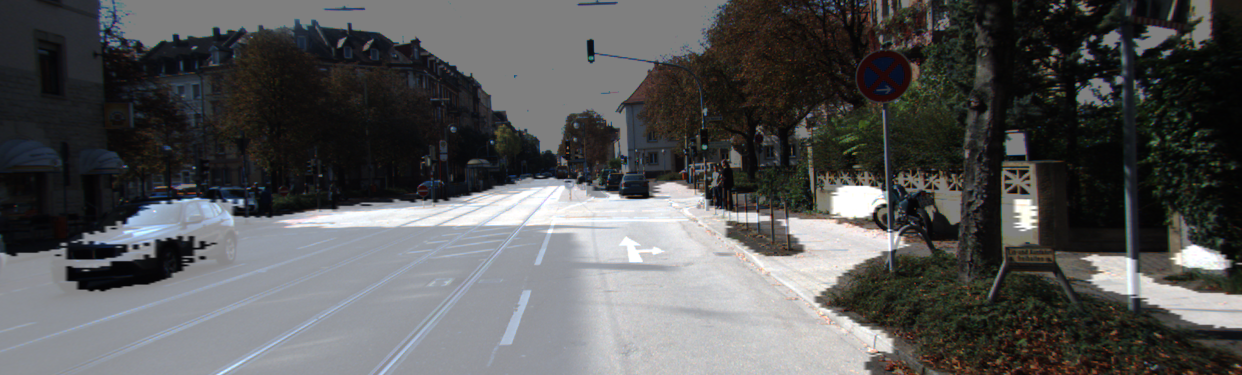

In [12]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

## U-net IOU 구하기

In [13]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [51]:
def get_output2(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

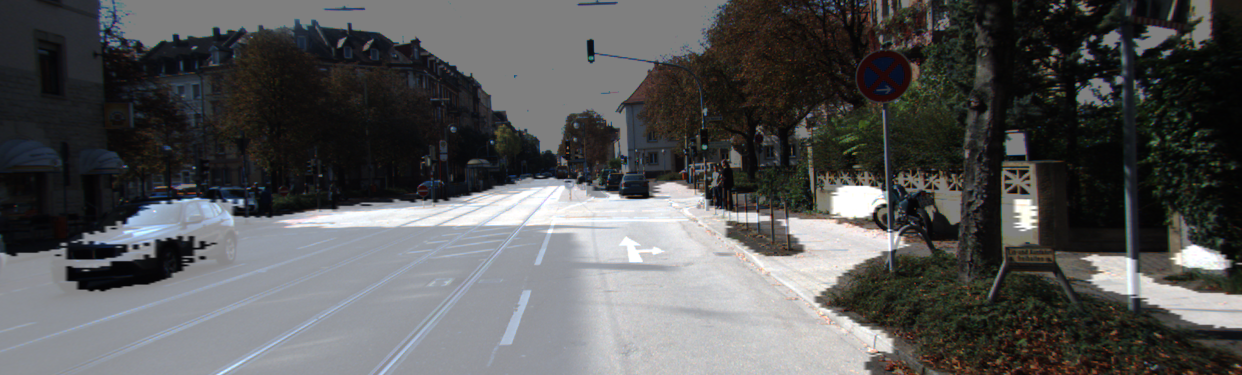

IoU : 0.795066


0.7950664136622391

In [52]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output2(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

## U-Net++ 모델 구현

In [16]:
def Upsample2D_block(filters, stage, cols, kernel_size=(3,3), upsample_rate=(2,2),
                     use_batchnorm=False, skip=None):

    def layer(input_tensor):

        conv_name, bn_name, relu_name, up_name, merge_name = handle_block_names(stage, cols)

        x = UpSampling2D(size=upsample_rate, name=up_name)(input_tensor)

        if (type(skip) != list and skip is not None) or (type(skip) == list and None not in skip):
            if type(skip) is list:
                x = Concatenate(name=merge_name)([x] + skip)
            else:
                x = Concatenate(name=merge_name)([x, skip])

        x = ConvRelu(filters, kernel_size, use_batchnorm=use_batchnorm,
                     conv_name=conv_name + '1', bn_name=bn_name + '1', relu_name=relu_name + '1')(x)

        x = ConvRelu(filters, kernel_size, use_batchnorm=use_batchnorm,
                     conv_name=conv_name + '2', bn_name=bn_name + '2', relu_name=relu_name + '2')(x)

        return x
    return layer


def Transpose2D_block(filters, stage, cols, kernel_size=(3,3), upsample_rate=(2,2),
                      transpose_kernel_size=(4,4), use_batchnorm=False, skip=None):

    def layer(input_tensor):

        conv_name, bn_name, relu_name, up_name, merge_name = handle_block_names(stage, cols)

        x = Conv2DTranspose(filters, transpose_kernel_size, strides=upsample_rate,
                            padding='same', name=up_name, use_bias=not(use_batchnorm))(input_tensor)
        if use_batchnorm:
            x = BatchNormalization(name=bn_name+'1')(x)
        x = Activation('relu', name=relu_name+'1')(x)

        if (type(skip) != list and skip is not None) or (type(skip) == list and None not in skip):
            # print("\nskip = {}".format(skip))
            if type(skip) is list:
                merge_list = []
                merge_list.append(x)
                for l in skip:
                    merge_list.append(l)
                x = Concatenate(name=merge_name)(merge_list)
            else:
                x = Concatenate(name=merge_name)([x, skip])

        x = ConvRelu(filters, kernel_size, use_batchnorm=use_batchnorm,
                     conv_name=conv_name + '2', bn_name=bn_name + '2', relu_name=relu_name + '2')(x)

        return x
    return layer

In [18]:
def Unet_plus_model (input_shape=(224, 224, 3)):
  inputs = Input(input_shape)
	
  #BACKBONE Path
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)
  
  # Middle Path
  up0_1 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv2)
  merge0_1 = concatenate([conv1,up0_1], axis = 3)
  conv0_1 =Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge0_1)
  conv0_1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv0_1)
  up1_1 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv3)
  merge1_1 = concatenate([conv2,up1_1], axis = 3)
  conv1_1 =Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge1_1)
  conv1_1 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_1)
  up2_1 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv4)
  merge2_1 = concatenate([conv3,up2_1], axis = 3)
  conv2_1 =Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge2_1)
  conv2_1 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2_1)
  up0_2 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv1_1)
  merge0_2 = concatenate([conv0_1,up0_2], axis = 3)
  conv0_2 =Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge0_2)
  conv0_2 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv0_2)
  up1_2 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv2_1)
  merge1_2 = concatenate([conv1_1,up1_2], axis = 3)
  conv1_2 =Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge1_2)
  conv1_2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_2)
  up0_3 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv1_2)
  merge0_3 = concatenate([conv0_2,up0_3], axis = 3)
  conv0_3 =Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge0_3)
  conv0_3 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv0_3)
  
  #Expanding Path
  drop5 = Dropout(0.5)(conv5)
  up6 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop5)
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
  up7 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv6)
  merge7 = concatenate([conv2_1,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
  up8 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv7)
  merge8 = concatenate([conv1_2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
  up9 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv8)
  merge9 = concatenate([conv0_3,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
  conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
  conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

  model = Model(inputs = inputs, outputs = conv10)
  return model

In [20]:
model2 = Unet_plus_model()
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 224, 224, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 224, 224, 64) 36928       conv2d_20[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 112, 112, 64) 0           conv2d_21[0][0]                  
____________________________________________________________________________________________

In [41]:
import keras
from keras import backend as K
# Custom loss function
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1. - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

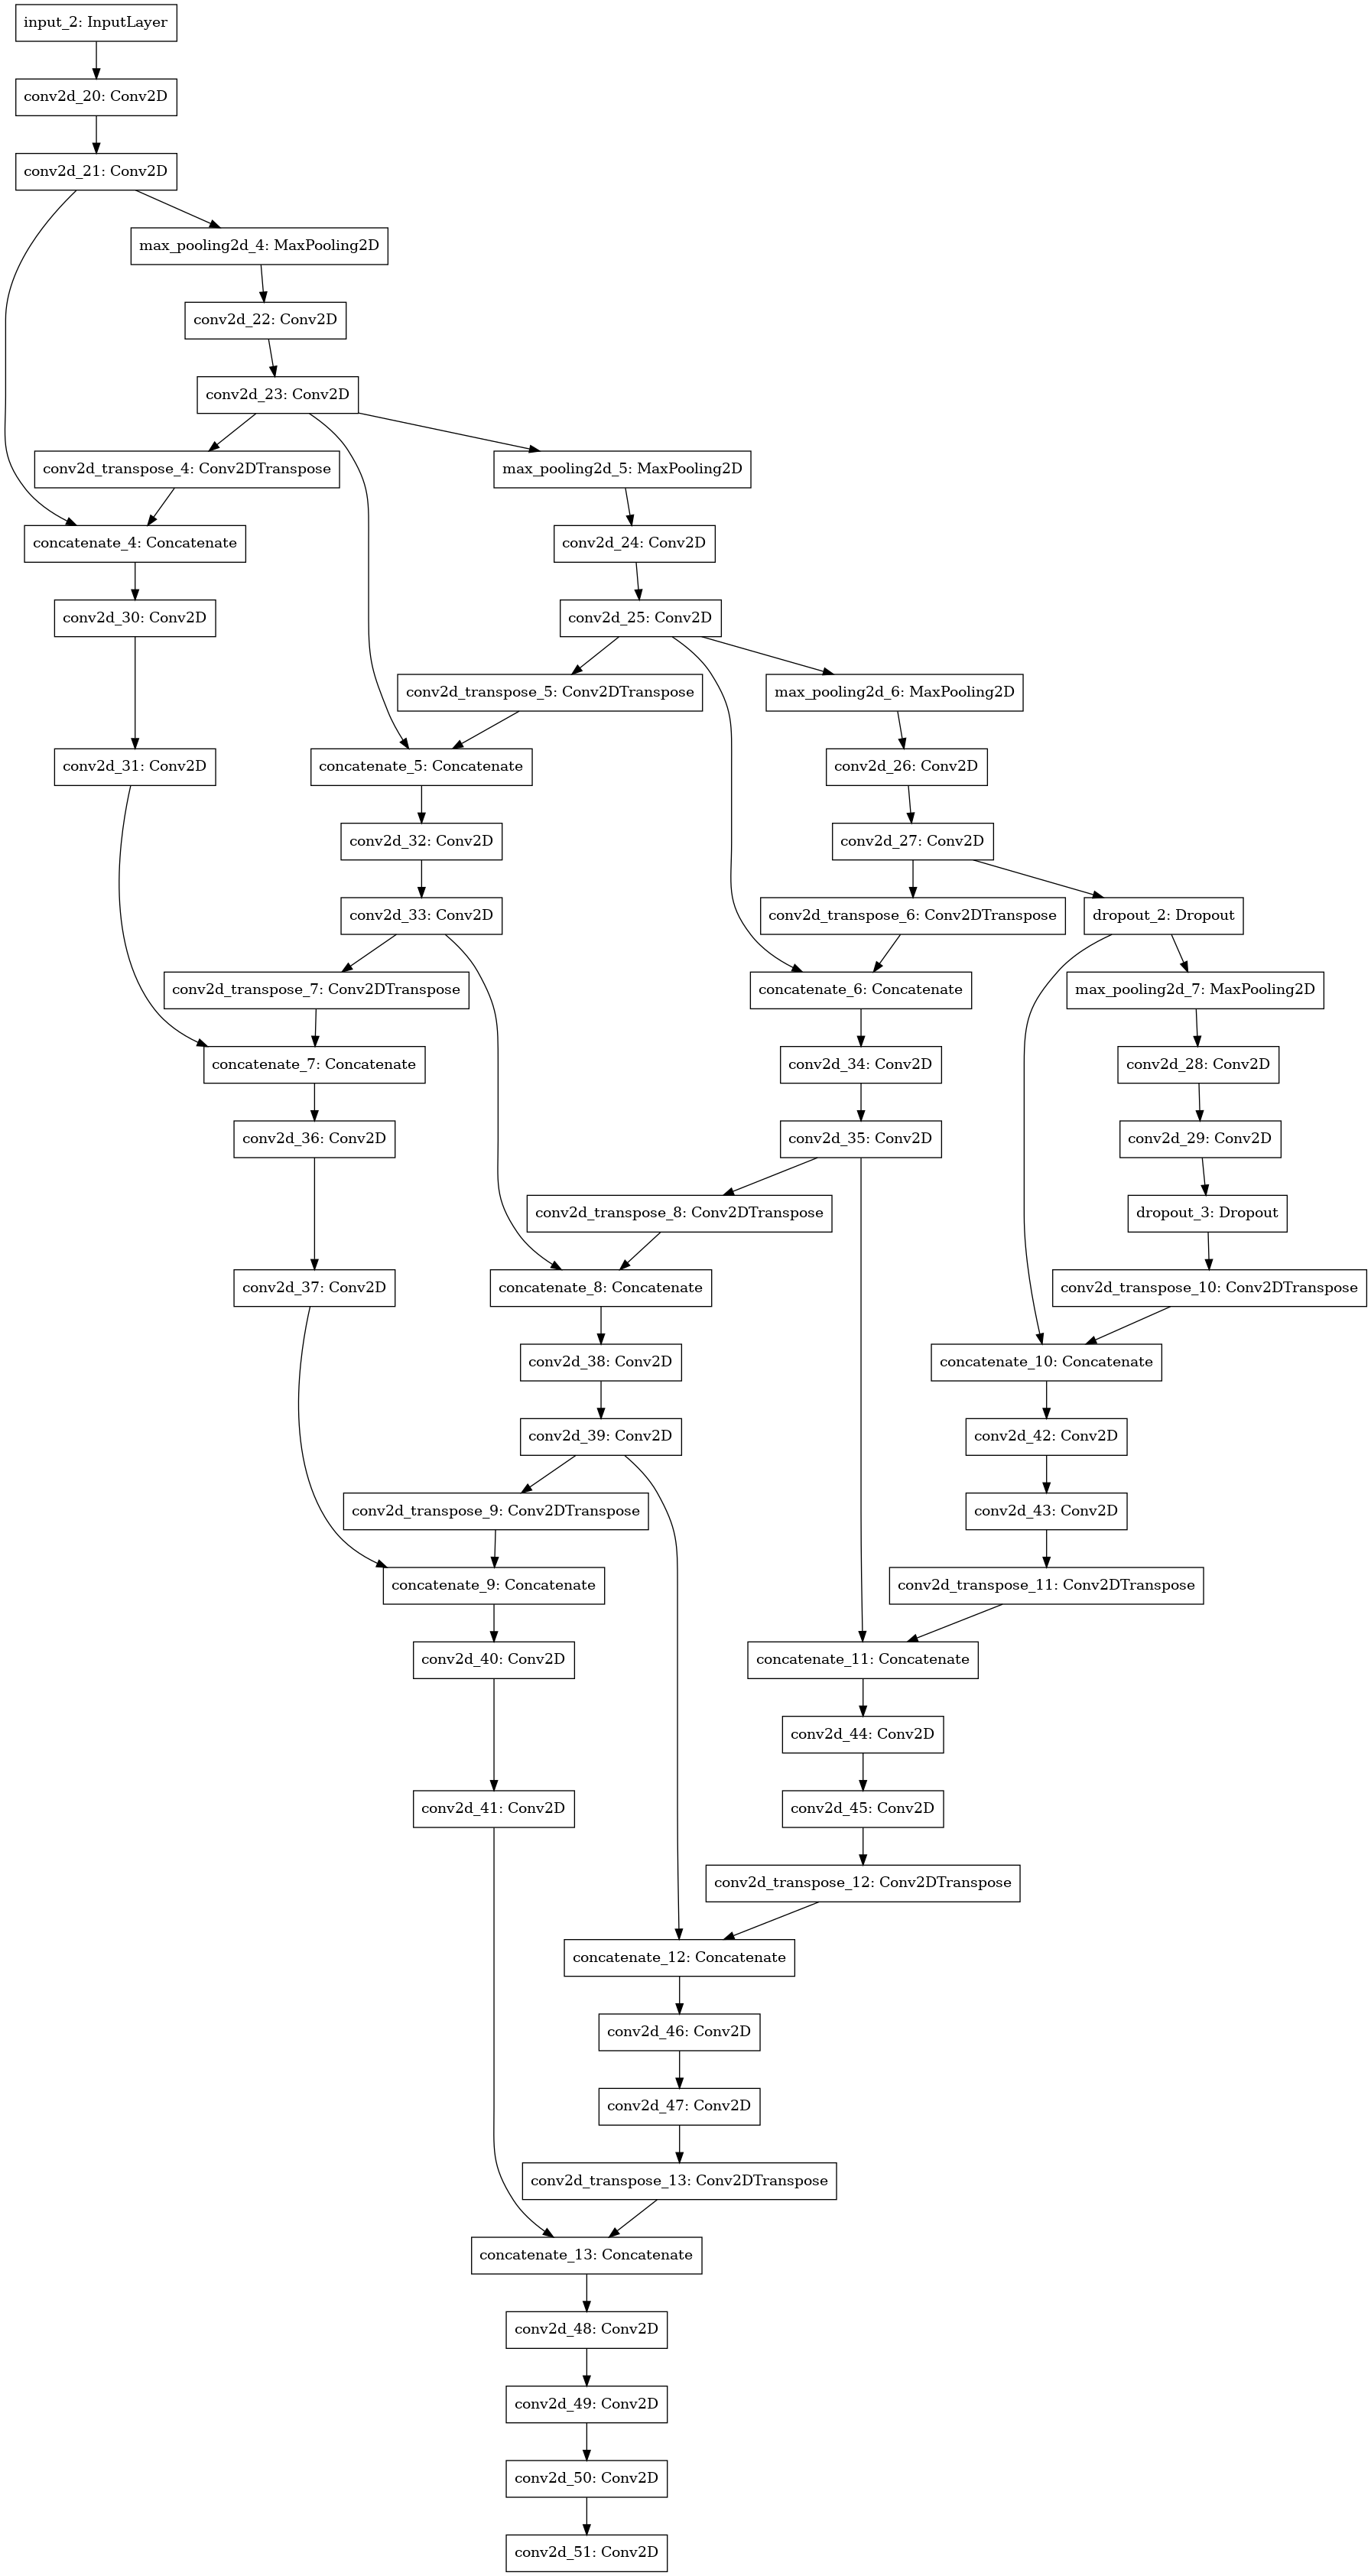

In [44]:
tf.keras.utils.plot_model(model2, to_file='Unet_plus_model.png')

In [42]:
model2_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet_plus.h5'


model2.compile(optimizer = Adam(1e-4), loss = bce_dice_loss)
model2.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model2.save(model2_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
11/11 [==============================] - 17s 1s/step - loss: 0.3207 - val_loss: 0.3085
Epoch 2/100
11/11 [==============================] - 15s 1s/step - loss: 0.2986 - val_loss: 0.2623
Epoch 3/100
11/11 [==============================] - 14s 1s/step - loss: -0.0380 - val_loss: -0.4922
Epoch 4/100
11/11 [==============================] - 14s 1s/step - loss: -0.4470 - val_loss: -0.4415
Epoch 5/100
11/11 [==============================] - 14s 1s/step - loss: -0.5035 - val_loss: -0.6726
Epoch 6/100
11/11 [==============================] - 14s 1s/step - loss: -0.4367 - val_loss: -0.6681
Epoch 7/100
11/11 [==============================] - 14s 1s/step - loss: -0.6285 - val_loss: -0.7514
Epoch 8/100
11/11 [==============================] - 14s 1s/step - loss: -0.6454 - val_loss: -0.7353
Epoch 9/100
11/11 [==============================] - 14s 1s/step - loss: -0.2293 - val_loss: 0.1409
Epoch 10/100
11/11 [==============================] - 14s 1s/step - loss: -0.0930 - val_loss: 0.

11/11 [==============================] - 14s 1s/step - loss: -0.6670 - val_loss: -0.7701
Epoch 82/100
11/11 [==============================] - 14s 1s/step - loss: -0.8908 - val_loss: -0.7841
Epoch 83/100
11/11 [==============================] - 14s 1s/step - loss: -0.7960 - val_loss: -0.7903
Epoch 84/100
11/11 [==============================] - 14s 1s/step - loss: -0.6389 - val_loss: -0.7987
Epoch 85/100
11/11 [==============================] - 14s 1s/step - loss: -0.8990 - val_loss: -0.7939
Epoch 86/100
11/11 [==============================] - 14s 1s/step - loss: -0.8017 - val_loss: -0.7665
Epoch 87/100
11/11 [==============================] - 14s 1s/step - loss: -0.8729 - val_loss: -0.7928
Epoch 88/100
11/11 [==============================] - 14s 1s/step - loss: -0.8607 - val_loss: -0.7899
Epoch 89/100
11/11 [==============================] - 14s 1s/step - loss: -0.8964 - val_loss: -0.8057
Epoch 90/100
11/11 [==============================] - 14s 1s/step - loss: -0.8867 - val_loss: -

loss 값이 음의 값이 나왔는데 이것을 설명하자면

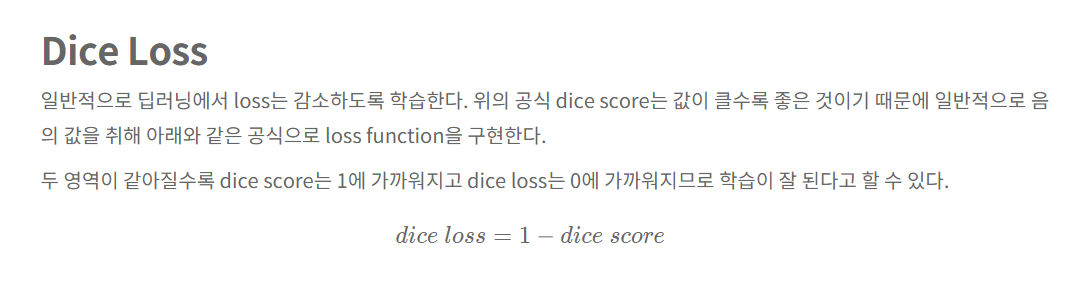

값이 작을수록 dice score가 크고 학습이 잘 되었다고 볼 수 있다.

### 모델 훈련 결과 시각화 Unet++

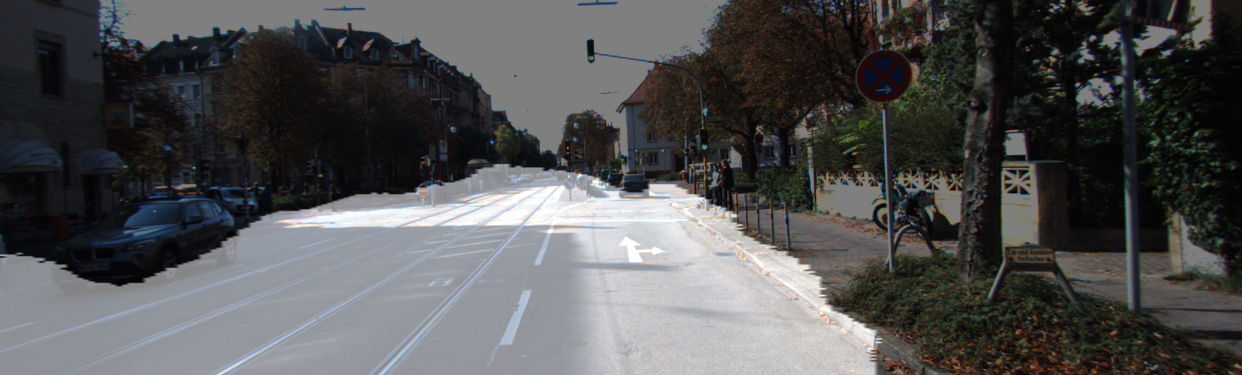

In [50]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model2, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

## Unet++ IoU 출력해보기 및 Unet과 비교

###  Unet ++ IOU

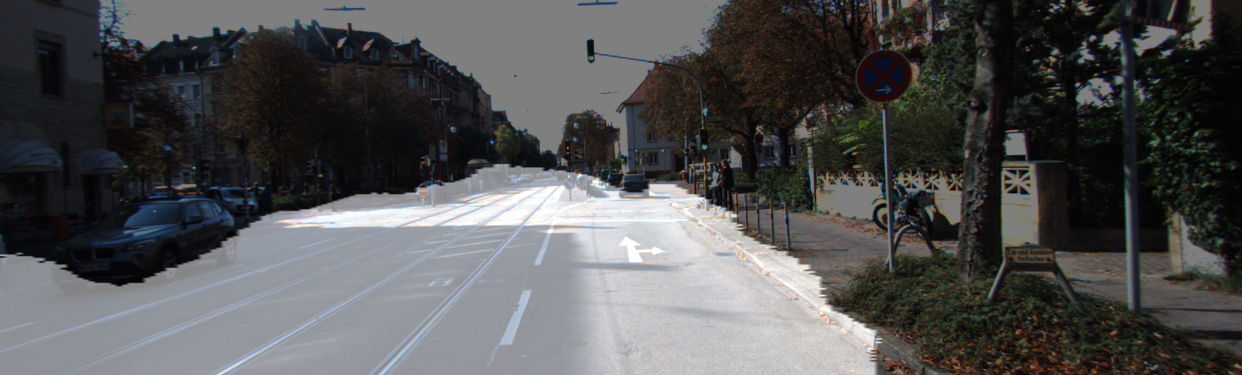

IoU : 0.884594


0.884593837535014

In [54]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output2(
     model2, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
        label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

### Unet IOU

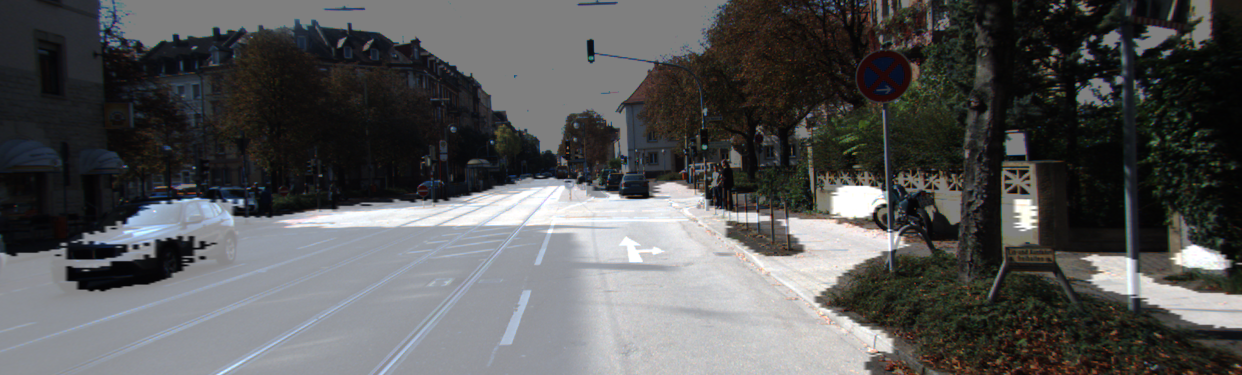

IoU : 0.795066


0.7950664136622391

In [55]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output2(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

비교를 해보면 Unet++ 가 IoU : 0.884594 Unet은IoU : 0.795066으로 U net ++가 더 우월 한 성능을 내는 것을 확인 할 수 있었다.

###  회고 

처음에는 모델 구성하는 것에 어려울 것 같았지만 막상 해보니 잘 되서 다행이다. 모델을 연결하는 과정이 꽤나 흥미로웠던것 같다. 